# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, `TfmOver`, and `Transform`

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

## Overview

In the second half of this page we'll look at complete examples of loading and using datasets using the `fastai.data` low-level APIs. But first, let's look at simple examples of the following applied to a single filename:

- `Transform`, including with `is_tuple=True`
- `Pipeline` to composes transforms
- `TfmOver` to apply transforms over an input collection

(We won't look at `TfmdList` or `DataSource` in this initial overview since they require a full dataset. Have a look at the second half of the page for examples of those.)

### Transform

First we'll have a look at the basic steps using a single MNIST image.

Let's start with a filename, and see step by step how it can be converted in to a labelled image that can be displayed and used for modeling.

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)

In [ ]:
fn = items[0]; fn

PosixPath('/home/ubuntu/git/fastai_docs/dev/data/mnist_tiny/train/7/7010.png')

We'll look at each `Transform` needed in turn. Here's how we can open an image file:

In [ ]:
timg = Imagify(cmap="Greys")
img = timg(fn); img

Then create a `c*h*w` tensor:

In [ ]:
tconv = ImageToByteTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([1, 28, 28]), torch.Tensor)

Now that's done, we can create our labels. First extracting the text label:

In [ ]:
lbl = parent_label(fn); lbl

'7'

And then converting to an int for modeling:

In [ ]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl

1

We use `decode` to reverse transforms for display. Reversing the image transforms results in a `h*w*c` image we can display:

In [ ]:
img = timg.decode(tconv.decode(img))
img.shape

torch.Size([28, 28])

Transforms can also show items:

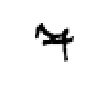

In [ ]:
timg.show(img, figsize=(1,1));

Reversing the label transforms retrieves the original text label:

In [ ]:
tcat.decode(lbl)

'7'

### Pipeline

We can compose our image steps using `Pipeline`:

In [ ]:
pipe = Pipeline([timg,tconv])

If you use `Pipeline` on its own (rather than in a `TfmdList` or `DataSource`) you need to call `setup` before using it.

In [ ]:
pipe.setup()
img = pipe(fn)
img.shape

torch.Size([1, 28, 28])

A `Pipeline` can decode and show an item.

In [ ]:
pipe.decode(img).shape

torch.Size([28, 28])

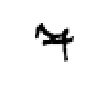

In [ ]:
pipe.show(img, figsize=(1,1));

### TfmOver

`TfmOver` will run multiple pipelines over an input collection. For instance, we can simultaneously do both labeling and image opening:

In [ ]:
tover = TfmOver([[timg,tconv], [parent_label,tcat]])
tover.setup()

`TfmOver` expects a collection input, so we'll need to duplicate `fn` as input:

In [ ]:
x,y = tover((fn,fn))
x.shape,y

(torch.Size([1, 28, 28]), 1)

Decoding a `TfmOver` will decode each item using the corresponding transform.

In [ ]:
xd,yd = tover.decode((x,y))
xd.shape,yd

(torch.Size([28, 28]), '7')

Because it is rather awkward to have to duplicate the input, a classmethod `TfmOver.piped` is provided that starts a `Pipeline` with a function that duplicates your input automatically, prior to calling `TfmOver`:

In [ ]:
tover = TfmOver.piped([[timg,tconv], [parent_label,tcat]])
tover.setup()
x,y = tover(fn)  # NB: Only one input
x.shape,y

(torch.Size([1, 28, 28]), 1)

### is_tuple=True

An alternative way to achieve the above is to remove `tconv` from the image pipeline, and instead add it to the pipeline later.

In [ ]:
tover = TfmOver([[timg], [parent_label,tcat]])

By adding it after `tover`, it will receive a tuple as input, but we only want to apply the transform to one element of the input, passing the other element along unchanged. A transform created with `is_tuple` works in this way, only getting applied to those items where `mask` (which defaults to `(True,False)`) is `True`.

In [ ]:
pipe = Pipeline([tover, ImageToByteTensor(is_tuple=True)])
pipe.setup()
x,y = pipe((fn,fn))
x.shape,y

(torch.Size([1, 28, 28]), 1)

Transforms passed in `final_tfms` of `TfmOver.piped` are added to the pipeline with `is_tuple` set automatically:

In [ ]:
tover = TfmOver.piped([[timg], [parent_label,tcat]], final_tfms=ImageToByteTensor())
tover.setup()
x,y = tover(fn)
x.shape,y

(torch.Size([1, 28, 28]), 1)

## Loading the Pets dataset using only `Transform`

Let's see how to use `fastai.data` to process the Pets dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

First we grab the items and split indices:

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

We'll use this function to create consistently sized tensors from image files:

In [ ]:
def resized_image(fn, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

We need to create a `Transform` that converts from an index to our `x` and `y` for modeling.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        super().__init__()
        self.items,self.train_idx,self.assoc = items,train_idx,TitledImageItem()
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return resized_image(o), self.o2i[self.labeller(o)]
    
    def decodes(self, o): return o[0],self.vocab[o[1]]

We can now create the `PetTfm`. We pass the training set indices to the constructor so it can create a vocab from only those items.

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets[0]
x.shape,y

(torch.Size([3, 128, 128]), 23)

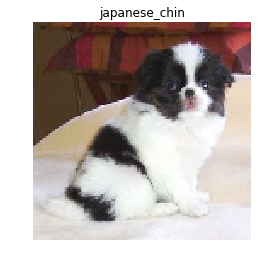

In [ ]:
pets.show((x,y))

## Using `Pipeline` to create Siamese model dataset

A *Siamese* model needs a dataset with two images as input, and a boolean output that is `True` if the two images are the "same" (e.g. are pictures of the same breed of pet). Custom structures like this are often easiest to create using `Pipeline`, which makes no assumptions about the structure of your input or output data.

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        super().__init__()
        self.items,self.labels,self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -> (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        x = (self.items[i], self.items[otherit])
        return x, self.labels[otherit]==self.labels[i]
    
    def shows(self, o, ctx=None):
        (x1,x2),y = o
        show_image(torch.cat([x1,x2], dim=2), title=y, ctx=ctx)

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
sp = SiamesePair(items, items.mapped(labeller))
resized_images = Transform(mapper(resized_image), is_tuple=True)
pipe = Pipeline([sp, resized_images])
pipe.setup()

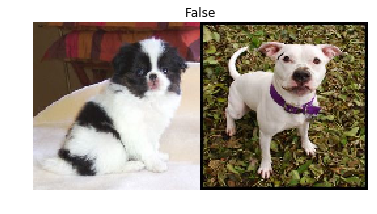

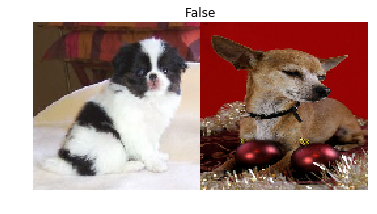

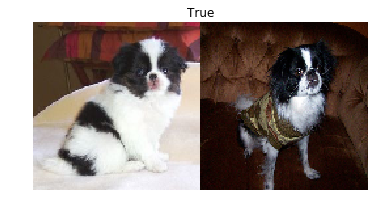

In [ ]:
for _ in range(3): pipe.show_at(0)

## Using `TfmOver`

`TfmOver` applies a list of transforms lazily to items of a collection, creating one output per transform. If passed lists of transforms, it creates `Pipeline`s of those lists. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.

We use the `piped` factory method to have a single item input (in this case, a filename) replicated to create a tuple the same length as `tfms`.

In [ ]:
c = Categorize(subset_idx=split_idx[0])
tfms = [[Imagify(), ImageResizer(128), ImageToByteTensor(), ByteToFloatTensor()],
        [labeller, c]]
pl = TfmdList(items, TfmOver.piped(tfms))

In [ ]:
t = pl[0]
x,y = pl.decode(t)
x.shape,y

(torch.Size([128, 128, 3]), 'japanese_chin')

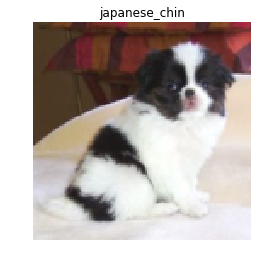

In [ ]:
pl.show(t);

## Using `DataSource`

In [ ]:
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()]
tfms = [Imagify(), [labeller, Categorize()]]

The quick way to create the `DataSource`:

In [ ]:
pets = DataSource.build(items, tfms, split_idx, ds_img_tfms)

Behind the scenes, this is using `TfmOver.piped`, which creates a `Pipeline` containing an initial `TfmOver` transform, followed by anything passed to `final_tfms`. All `final_tfms` are automatically marked as `is_tuple` (unless specifically marked `is_tuple=False` at creation).

In [ ]:
tfm = TfmOver.piped(tfms, final_tfms=ds_img_tfms)
pets = DataSource(items, tfm, filts=split_idx)

To access an element we need to specify the subset (either with `train`/`valid` or with `subset(i)`):

In [ ]:
x,y = pets.subset(1)[0]
x.shape,y

(torch.Size([3, 128, 128]), 4)

...or equivalently:

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index to `decode_at`.

In [ ]:
xy = pets.valid.decode((x,y))
xy[1]

'British_Shorthair'

In [ ]:
xy2 = pets.valid.decode_at(0)
test_eq(type(xy2[1]), str)
test_eq(xy2, xy)

We're now ready to show our items.

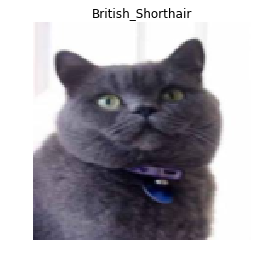

In [ ]:
pets.show((x,y))

We can use this to feed a `DataLoader` and view a batch. It's faster to convert to float on GPU, so we'll do it as a DataLoader transform, after CUDA.

In [ ]:
dl_tfms = [Cuda(), ByteToFloatTensor()]
trn_dl = TfmdDL(pets.train, dl_tfms, bs=9)
b = trn_dl.one_batch()

test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor')

In [ ]:
bd = trn_dl.decode(b)

test_eq(len(bd[0]), 9)
test_eq(bd[0][0].shape, (128,128,3))

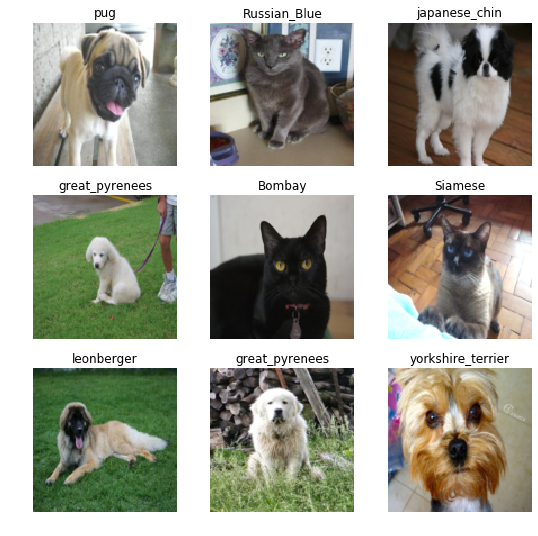

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
trn_dl.show_batch(ctxs=axs.flatten())

## Segmentation

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
for t in ds_img_tfms: t.mask = (True,True)
tfms = [[Imagify()],
        [cv_label, Imagify(cmap='tab20', alpha=0.5, vmin=1, vmax=30)]]
camvid = DataSource.build(cv_items, tfms, cv_split, ds_img_tfms)
trn_dl = TfmdDL(camvid.train, dl_tfms, 4)

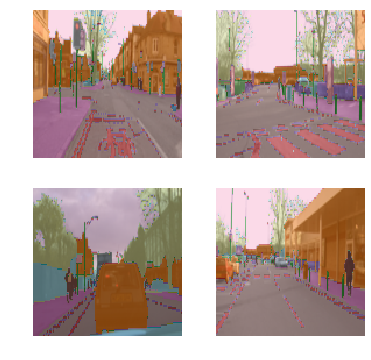

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

## fin -